In [1]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None
    rca_bb_offset: float = 128.9

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("frequencies", mode="before")
    @classmethod
    def convert_freqs(cls, values):
        """Convert kHz to Hz by multiplying each element by 1000."""
        return [v * 1000 for v in values]

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if self.sens is not None:
            print("creating only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
        elif self.sens0 is not None and self.sens90 is not None:
            print("creating both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "asset_id": self.asset_id,
                "model": self.model,
                "serial_number": self.sn,
                "calibration_date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc", mode="w")

    def save_correction_cal(self):
        if self.sens is not None:
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 
        elif self.sens0 is not None and self.sens90 is not None:
            self.ds["sensitivity"] = (self.ds["sensitivity_0"] + self.ds["sensitivity_90"]) / 2
            self.ds["sensitivity"] = self.ds["sensitivity"] + self.rca_bb_offset 

        self.ds.to_netcdf(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc", mode="w")
        
        

In [4]:
refdes = "RS03AXBS-LJ03A-09-HYDBBA302"
deployment = "4"

In [5]:
asset_id = "ATAPL-58324-00011"	 #
model = "SB35-ETH"  #
sn = 1389  #
cal_date = datetime(2015, 5, 19)  #
frequency = [
10.0,
20.1,
30.1,
40.2,
50.2,
60.2,
70.3,
80.3,
90.4,
100.4,
110.4,
120.5,
130.5,
140.5,
150.6,
160.6,
170.7,
180.7,
190.7,
200.0
]
sens0 = [
-169.8,
-170.3,
-171.1,
-170.3,
-173.0,
-172.4,
-175.2,
-176.3,
-177.4,
-176.6,
-177.3,
-176.6,
-175.0,
-172.5,
-171.3,
-167.1,
-167.6,
-170.0,
-172.7,
-176.4
]
sens90 = [
-169.7,
-170.8,
-170.8,
-170.7,
-174.2,
-173.3,
-174.0,
-173.6,
-175.2,
-175.4,
-177.7,
-176.7,
-175.2,
-173.7,
-169.7,
-168.5,
-166.3,
-169.6,
-173.5,
-174.4
]

In [6]:
hyd = HydCal(
    refdes=refdes,
    deployment=deployment,
    asset_id=asset_id,
    model=model,
    sn=sn,
    cal_date=cal_date,
    frequencies = frequency,
    #sens=sensitivity,
    sens0=sens0,
    sens90=sens90,
    )

hyd.make_ndarray()

creating both 0 and 90 degree sensitivities


In [7]:
hyd.cal_date

'2015-05-19T00:00:00.000000Z'

In [8]:
hyd.ds.sensitivity.plot()  # Plot the DataArray

AttributeError: 'Dataset' object has no attribute 'sensitivity'

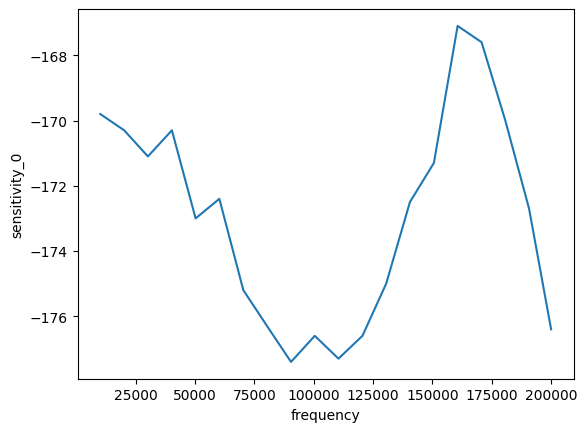

In [9]:
hyd.ds["sensitivity_0"].plot()  # Plot the DataArray

In [10]:
hyd.save_cal()
hyd.save_correction_cal()

In [11]:
test = xr.open_dataset(f"../metadata/rca_correction_cals/{refdes}_{deployment}.nc")

In [12]:
test.sensitivity.values

array([-40.85, -41.65, -42.05, -41.6 , -44.7 , -43.95, -45.7 , -46.05,
       -47.4 , -47.1 , -48.6 , -47.75, -46.2 , -44.2 , -41.6 , -38.9 ,
       -38.05, -40.9 , -44.2 , -46.5 ])

In [16]:
test

<xarray.Dataset>
Dimensions:         (frequency: 20)
Coordinates:
  * frequency       (frequency) float64 1e+04 2.01e+04 ... 1.907e+05 2e+05
Data variables:
    sensitivity_0   (frequency) float64 ...
    sensitivity_90  (frequency) float64 ...
    sensitivity     (frequency) float64 -40.85 -41.65 -42.05 ... -44.2 -46.5
Attributes:
    asset_id:          ATAPL-58324-00011
    model:             SB35-ETH
    serial_number:     1389
    calibration_date:  2015-05-19T00:00:00.000000Z

In [13]:
#product_viz = xr.open_dataset("/Users/joeduprey/repos/ooi-hyd-tools/output/HYDBBA106_20170401.nc")

In [14]:
#product_viz.sensitivity.values